In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from time import perf_counter

In [2]:
def iszero(z, reference = 1.0, dtype = np.float32):
    return np.abs(z) <= reference * np.finfo(dtype).eps

In [3]:
class Element:
    """Straight segment constant boundary element.

    Parameters
    ----------
    point1 : numpy.ndarray
        First end point global coordinates.
    point2 : numpy.ndarray
        Second end point global coordinates.
        
    Attributes
    ----------
    endpoints : numpy.ndarray
        Element end points' global coordinates.
    node : numpy.ndarray
        Midpoint between endpoints.
    length : float
        Element's length.
    tangent : numpy.ndarray
        Element's tangent vector.
    normal : numpy.ndarray
        Element's normal vector.

    Methods
    -------
    get_point_local_coordinates(point_global)
        Gets point's coordinates in local system.
    get_influence_coefficients(field_global, method='analytical')
        Gets influence coefficients at a given field point using the requested method.
    """

    def __init__(self, point1, point2):
        self.endpoints = np.array([point1, point2])
        self.node = self.endpoints.mean(axis=0)

        r = self.endpoints[1] - self.endpoints[0]
        self.length = np.linalg.norm(r)
        self.tangent = r / self.length
        self.normal = np.array([self.tangent[1], -self.tangent[0]])
        
    def get_point_local_coordinates(self, point_global):
        """Gets point's coordinates in local system.

        Parameters
        ----------
        point_global : numpy.ndarray
            Point's coordinates in global system.

        Returns
        -------
        point_local : numpy.ndarray
            Point's coordinates in local system.
        """

        dif = np.array(point_global) - self.node
        x = np.dot(dif, self.tangent)
        y = np.dot(dif, self.normal)
        point_local = np.array([x, y])

        return point_local

    def get_point_distance(self, point_global):
        """Gets point's distance from the element.
        
        Parameters
        ----------
        point_global : numpy.ndarray
            Point's coordinates in global system.

        Returns
        -------
        distance : float
            Point's distance from the element.
        """

        a = 0.5 * self.length
        x, y = self.get_point_local_coordinates(point_global)

        if np.abs(x) <= a:
            distance = np.abs(y)
        else:
            dif_from_endpoints = point_global - self.endpoints
            distance_from_endpoints = np.linalg.norm(dif_from_endpoints, axis=1)
            distance = distance_from_endpoints.min()

        return distance
    
    def get_influence_coefficients(self, field_global, method = 'analytical'):
        """Gets influence coefficients at a given field point using the requested method.

        Parameters
        ----------
        field_global : numpy.ndarray
            Field point's coordinates in global system.
        method : string, default='analytical'
            Evaluation method of line integrals. Three method are available:
            'analytical', 'gauss' and 'quad'.

        Returns
        -------
        G : float
            Integral of the Green's function over the element.
        Q : float
            Integral of the normal derivative of Green's function over the element.

        Raises
        ------
        ValueError
            If requested method is invalid.
        """

        x, y = self.get_point_local_coordinates(field_global)

        if iszero(x, self.length) and iszero(y, self.length):
            a = 0.5 * self.length
            G = a / np.pi * (np.log(a) - 1)
            Q = 0.0

            return G, Q
        
        _method = method.strip().lower()

        if _method == 'analytical':
            G, Q = self.get_influence_coefficients_analytical(field_global)
        elif _method == 'gauss':
            G, Q = self.get_influence_coefficients_gauss(field_global)
        elif _method == 'quad':
            G, Q = self.get_influence_coefficients_quad(field_global)
        else:
            raise ValueError(f"Invalid method: {method}")

        return G, Q
    
    def get_influence_coefficients_analytical(self, field_global):
        """Gets influence coefficients at a given field point using analytical integration."""

        a = 0.5 * self.length
        field_local = self.get_point_local_coordinates(field_global)
        x, y = field_local

        if iszero(y, self.length) and iszero(np.abs(x) - a, self.length):
            G = a / np.pi * (np.log(2*a) - 1)
            Q = 0.0
        else:
            xpa = x + a
            xma = x - a

            r1 = np.sqrt(xma**2 + y**2)
            r2 = np.sqrt(xpa**2 + y**2)
            t1 = np.arctan2(y, xma)
            t2 = np.arctan2(y, xpa)
    
            G = 0.5 / np.pi * (
                y * (t1 - t2)
                - xma * np.log(r1)
                + xpa * np.log(r2)
                - 2 * a
            )

            if iszero(y, self.length):
                # Q is discontinuous in |x| < a and y = 0.
                Q = 0.0
            else:
                Q = -0.5 / np.pi * (t1 - t2)

        return G, Q

    def get_influence_coefficients_gauss(self, field_global):
        """Gets influence coefficients at a given field point using Gauss-Legendre quadrature."""

        a = 0.5 * self.length
        field_local = self.get_point_local_coordinates(field_global)
        x, y = field_local

        roots = [-0.8611363115940526, -0.3399810435848563,
                 0.3399810435848563, 0.8611363115940526]
        weights = [0.3478548451374538, 0.6521451548625461,
                   0.6521451548625461, 0.3478548451374538]

        intG = lambda t: np.log((x - t)**2 + y**2)
        intQ = lambda t: y / ((x - t)**2 + y**2)
        
        G = 0.25 * a / np.pi * np.sum([weights[i] * intG(a * roots[i]) for i in range(4)])
        Q = -0.5 * a / np.pi * np.sum([weights[i] * intQ(a * roots[i]) for i in range(4)])

        return G, Q
    
    def get_influence_coefficients_quad(self, field_global):
        """Gets influence coefficients at a given field point using the scipy.quad function."""
        
        a = 0.5 * self.length
        field_local = self.get_point_local_coordinates(field_global)
        x, y = field_local

        intG = lambda t: np.log((x - t)**2 + y**2)
        intQ = lambda t: y / ((x - t)**2 + y**2)
        
        singular_point = [x] if y == 0 else None
        
        G = 0.25 / np.pi * quad(intG, -a, a, points=singular_point)[0]
        Q = -0.5 / np.pi * quad(intQ, -a, a, points=singular_point)[0]

        return G, Q

In [4]:
def get_time(element, field_point, method = 'analytical', number_of_loops = 1000):
    start_time = perf_counter()
    
    for _ in range(number_of_loops):
        G , Q = element.get_influence_coefficients(field_point, method=method)

    end_time = perf_counter()
    elapsed_time = (end_time - start_time) / number_of_loops

    return elapsed_time

In [5]:
def set_field_points(element, radius, num_points = 1000):
    np.random.seed(18)
    r = radius * np.random.uniform(0, 1, num_points)
    t = np.random.uniform(0, 2*np.pi, num_points)
    x = element.node[0] + r * np.cos(t)
    y = element.node[1] + r * np.sin(t)
    field_points = np.column_stack((x, y))

    too_close = np.empty(num_points, dtype=bool)
    distances = np.empty(num_points)
    for i, point in enumerate(field_points):
        dist = element.get_point_distance(point)
        too_close[i] = iszero(dist, element.length)
        distances[i] = element.get_point_distance(point)

    # Removing points too close to the element.
    field_points = field_points[~too_close]
    distances = distances[~too_close]

    return field_points, distances

In [6]:
# Element of unitary length.
point1 = [0.0, 0.0]
point2 = [1.0, 0.0]
e = Element(point1, point2)

In [7]:
field_points, distances = set_field_points(e, 10.0)
norm_distances = distances / e.length

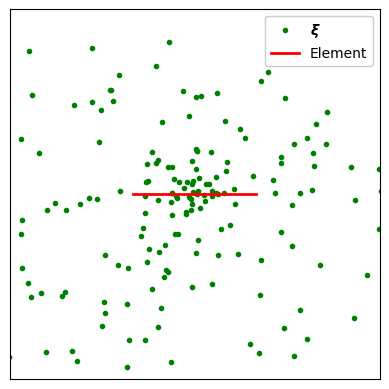

In [8]:
# Plot of all field points. Displays only the close ones.
plt.plot(field_points[:, 0], field_points[:, 1], '.g', label=r'$\boldsymbol{\xi}$')
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r-', linewidth=2, label='Element')
plt.gca().set_aspect('equal')
plt.xlim(-1.0, 2.0)
plt.ylim(-1.5, 1.5)
plt.xticks([])
plt.yticks([])
plt.legend(loc='upper right', framealpha=1)

plt.savefig('test_points.svg', bbox_inches='tight')
plt.show()

In [9]:
# Computation of influence coefficients using the three implemented methods.
analytical, gauss, scipy_quad = [np.empty(field_points.shape) for _ in range(3)]
for i in range(len(field_points)):
    analytical[i] = e.get_influence_coefficients(field_points[i], method='analytical')
    gauss[i] = e.get_influence_coefficients(field_points[i], method='gauss')
    scipy_quad[i] = e.get_influence_coefficients(field_points[i], method='quad')

In [10]:
# Absolute error between gauss (or scipy.quad) and analytical.
err_scipy_quad = np.abs(scipy_quad - analytical)
err_gauss = np.abs(gauss - analytical)

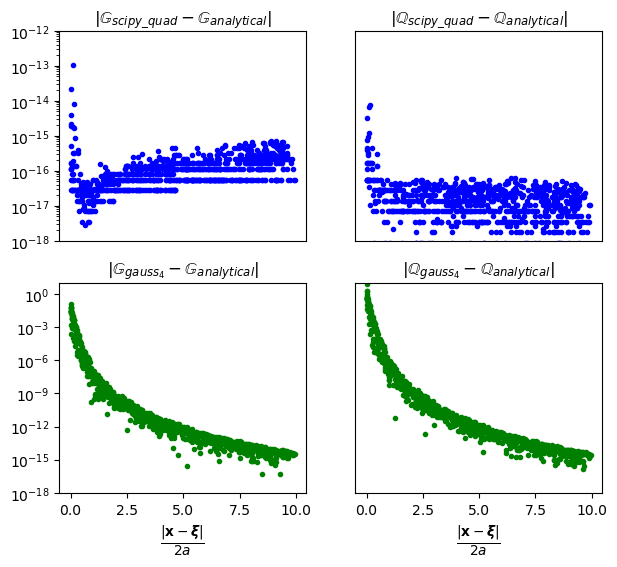

In [11]:
# Plot of absolute error as a function of the distance between the field point and the element node.
fig, ax = plt.subplots(2, 2, figsize=(7,6))

ax[0, 0].set_title(r'$|\mathbb{G}_{scipy\_quad} - \mathbb{G}_{analytical}|$')
ax[0, 0].semilogy(distances, err_scipy_quad[:, 0], 'b.')
ax[0, 0].set_ylim((1.0e-18, 1.0e-12))

ax[0, 1].set_title(r'$|\mathbb{Q}_{scipy\_quad} - \mathbb{Q}_{analytical}|$')
ax[0, 1].semilogy(distances, err_scipy_quad[:, 1], 'b.')
ax[0, 1].set_ylim((1.0e-18, 1.0e-12))

ax[1, 0].set_title(r'$|\mathbb{G}_{gauss_4} - \mathbb{G}_{analytical}|$')
ax[1, 0].set_xlabel(r'$\frac{|\mathbf{x} - \boldsymbol{\xi}|}{2a}$', fontsize=14)
ax[1, 0].semilogy(distances, err_gauss[:, 0], 'g.')
ax[1, 0].set_ylim((1.0e-18, 1.0e1))

ax[1, 1].set_title(r'$|\mathbb{Q}_{gauss_4} - \mathbb{Q}_{analytical}|$')
ax[1, 1].set_xlabel(r'$\frac{|\mathbf{x} - \boldsymbol{\xi}|}{2a}$', fontsize=14)
ax[1, 1].semilogy(distances, err_gauss[:, 1], 'g.')
ax[1, 1].set_ylim((1.0e-18, 1.0e1))

ax[0, 0].xaxis.set_visible(False)
ax[0, 1].xaxis.set_visible(False)
ax[0, 1].yaxis.set_visible(False)
ax[1, 1].yaxis.set_visible(False)

plt.savefig('GQ_abs_error.svg', bbox_inches='tight')
plt.show()

In [12]:
# Evaluation of time required by each method to compute the influence coefficients for each field point.
# It can take some time. It's a good idea to save it and load it later.
# time_analytical, time_gauss, time_scipy_quad = [np.empty(len(field_points)) for _ in range(3)]
# for i in range(len(field_points)):
#     time_analytical[i] = get_time(e, field_points[i], method='analytical')
#     time_gauss[i] = get_time(e, field_points[i], method='gauss')
#     time_scipy_quad[i] = get_time(e, field_points[i], method='quad')

# np.save('time_analytical.npy', time_analytical)
# np.save('time_gauss.npy', time_gauss)
# np.save('time_scipy_quad.npy', time_scipy_quad)

time_analytical = np.load('time_analytical.npy')
time_gauss = np.load('time_gauss.npy')
time_scipy_quad = np.load('time_scipy_quad.npy')

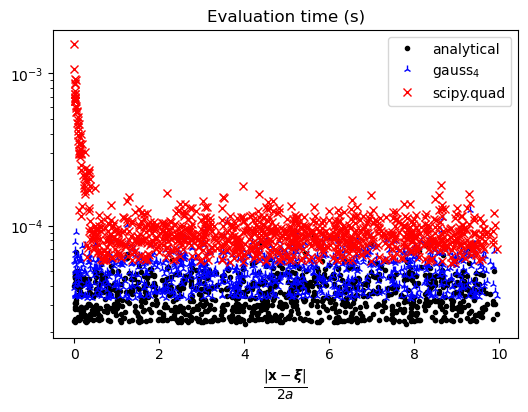

In [13]:
# Plot evaluation time as a function of the distance between the field point and the element node.
plt.figure(figsize=(6, 4))
plt.semilogy(distances, time_analytical, 'k.', label='analytical')
plt.semilogy(distances, time_gauss, 'b2', label='gauss$_4$')
plt.semilogy(distances, time_scipy_quad, 'rx', label='scipy.quad')
plt.title('Evaluation time (s)')
plt.xlabel(r'$\frac{|\mathbf{x} - \boldsymbol{\xi}|}{2a}$', fontsize=14)
plt.legend()

plt.savefig('eval_time.svg', bbox_inches='tight')
plt.show()

In [14]:
time_gauss_analytical = np.mean(time_gauss) / np.mean(time_analytical)
time_quad_analytical = np.mean(time_scipy_quad) / np.mean(time_analytical)

print(f'In average, Gauss integration with 4 points takes {time_gauss_analytical:.1f} times longer than analytical integration.')
print(f'In average, scipy.quad takes {time_quad_analytical:.1f} times longer than analytical integration.')

In average, Gauss integration with 4 points takes 1.4 times longer than analytical integration.
In average, scipy.quad takes 3.1 times longer than analytical integration.
